# License

***

J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Imports and Setup

***

In [130]:
import os
import time
import sys
import re
import subprocess

# in-notebook display
from IPython.display import Image
from IPython.display import display

from data_maker_and_getter import DataMakerAndGetter
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
from h2o.backend import H2OLocalServer
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
import pandas as pd
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

pd.options.display.max_columns = 999 # enable display of all columns in notebook

In [2]:
%matplotlib inline

In [122]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 hours 15 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,5 months and 9 days !!!
H2O cluster name:,H2O_from_python_patrickh_6m6l0g
H2O cluster total nodes:,1
H2O cluster free memory:,10.37 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


#  Explore and prepare diabetes data

***

#### Import data and examine

In [4]:
# import CSV file
train = pd.read_csv('data/diabetes_train.csv')
test = pd.read_csv('data/diabetes_test.csv')

In [5]:
train.head(n=10)

,id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
6,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,36900,77391171,AfricanAmerican,Male,[60-70),?,2,1,4,7,?,?,62,0,11,0,0,0,157,288,197,7,None,None,No,No,No,No,No,No,No,Up,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30
8,40926,85504905,Caucasian,Female,[40-50),?,1,3,7,7,?,Family/GeneralPractice,60,0,15,0,1,0,428,250.43,250.6,8,None,None,Steady,Up,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,<30
9,42570,77586282,Caucasian,Male,[80-90),?,1,6,7,10,?,Family/GeneralPractice,55,1,31,0,0,0,428,411,427,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO


#### Examine high cardinality inputs

In [6]:
for col in train.select_dtypes(include=['object']):
    n_levels = len(train[col].unique())
    if n_levels > 20:
        print(col + ' levels: ', train[col].unique())
        print()

medical_specialty levels:  ['Pediatrics-Endocrinology' '?' 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedics'
 'Gastroenterology' 'Nephrology' 'Orthopedics-Reconstructive'
 'Surgery-Cardiovascular/Thoracic' 'Pulmonology' 'Psychiatry'
 'Emergency/Trauma' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Otolaryngology'
 'Surgery-Colon&Rectal' 'Urology' 'Psychiatry-Child/Adolescent'
 'Endocrinology' 'Neurology' 'Anesthesiology-Pediatric'
 'Pediatrics-CriticalCare' 'Radiology' 'Pediatrics-Hematology-Oncology'
 'Psychology' 'Hematology/Oncology' 'Podiatry' 'Gynecology' 'Oncology'
 'Pediatrics-Neurology' 'Surgery-Plastic' 'Surgery-Thoracic'
 'Surgery-Pediatric' 'Pediatrics-EmergencyMedicine'
 'PhysicalMedicineandRehabilitation' 'Pediatrics-Pulmonology'
 'Anesthesiology' 'Ophthalmology' 'InfectiousDiseases' 'Rheumatology'
 'AllergyandImmunology' 'Surgery-Maxillofacial' 'Surgeon'
 'Surgery-Vascular' 'Osteopat

 '750']

diag_3 levels:  ['?' 'V27' '403' '250' 'V45' '38' '486' '197' '250.6' '427' '996' '414'
 '714' '428' '582' '250.42' '998' '250.01' '618' '250.02' '305' '496'
 '599' '424' '553' '401' '794' '511' '276' '490' '562' '482' '250.7' '518'
 '411' '784' '491' '420' '8' '730' '131' '707' '41' '493' '529' '263'
 'E888' '425' '595' '560' '711' '296' '789' 'V43' '250.4' '654' 'V70'
 '625' '681' '250.51' 'V10' '280' '440' '244' '581' '569' '272' '250.43'
 '918' '54' '250.41' '788' '196' '461' '535' '584' '891' '332' '648'
 '250.03' '780' '182' '285' '278' '997' '413' '664' '201' 'V15' '292'
 '416' '473' '564' 'E932' '357' '348' 'E878' '437' '733' '525' '250.53'
 '397' '572' '805' '453' '331' '736' '250.8' '465' '533' '787' '349' '315'
 '658' '608' '786' '284' '382' '300' 'V42' '492' '438' '571' '536' '585'
 '644' '578' '682' 'V11' 'E885' '162' '198' '303' '412' '402' '396' 'V14'
 '570' '433' 'E934' '882' '288' '458' '785' '577' '729' '836' '799' '281'
 '616' '304' '250.83' '291' '512' '660

#### Utility function for simple binning of less common categorical levels

In [7]:
def bin_less_common_levels(train, test, col_name, in_list):
    
    """Places less common categorical levels into an 'Other' bin.
    
    :param train: Training set.
    :param test: Test set.
    :param col_name: Name of column in which to create 'Other' bin.
    :param in_list: List of levels NOT to be binned.  
    """
    
    train.loc[~train[col_name].isin(in_list), col_name] = 'Other'
    test.loc[~test[col_name].isin(in_list), col_name] = 'Other'   
                                    
    print('Train levels:\n', train[col_name].value_counts())
    print()
    print('Test levels:\n', test[col_name].value_counts())

#### Bin medical_specialty

In [8]:
in_list = list(train['medical_specialty'].value_counts()[:10].index)
bin_less_common_levels(train, test, 'medical_specialty', in_list)

Train levels:
 ?                             20893
InternalMedicine               8899
Other                          5162
Family/GeneralPractice         4370
Cardiology                     3037
Emergency/Trauma               2824
Surgery-General                1649
Orthopedics-Reconstructive      898
Nephrology                      883
Orthopedics                     839
Psychiatry                      547
Name: medical_specialty, dtype: int64

Test levels:
 ?                             10841
Emergency/Trauma               1735
InternalMedicine               1013
Other                           974
Cardiology                      462
Family/GeneralPractice          407
Surgery-General                 404
Orthopedics                     234
Nephrology                       64
Psychiatry                       45
Orthopedics-Reconstructive       42
Name: medical_specialty, dtype: int64


#### Bin diag_1

In [9]:
in_list = list(train['diag_1'].value_counts()[:20].index)
bin_less_common_levels(train, test, 'diag_1', in_list)

Train levels:
 Other    25298
414       3464
428       2924
786       2071
410       1992
486       1662
427       1256
715       1103
434       1103
780        974
682        936
996        909
276        895
38         799
491        791
250.8      709
599        689
584        677
V57        651
820        590
518        508
Name: diag_1, dtype: int64

Test levels:
 Other    8061
414       993
428       849
410       557
427       536
786       527
715       480
486       477
491       411
434       337
38        335
682       332
584       319
780       315
599       289
996       287
276       281
250.8     269
518       240
820       195
V57       131
Name: diag_1, dtype: int64


#### Bin diag_2

In [10]:
in_list = list(train['diag_2'].value_counts()[:20].index)
bin_less_common_levels(train, test, 'diag_2', in_list)

Train levels:
 Other     20558
250        3425
276        3399
428        3233
427        2564
401        2094
496        1681
599        1570
403        1373
411        1358
414        1248
250.02     1060
250.01      944
707         879
780         794
285         667
682         646
518         641
425         639
491         630
424         598
Name: diag_2, dtype: int64

Test levels:
 Other     8346
250        966
276        961
428        750
427        643
401        607
599        555
414        503
285        350
518        311
707        302
411        285
496        283
250.02     255
491        217
682        210
425        199
780        171
403        164
424         88
250.01      55
Name: diag_2, dtype: int64


#### Bin diag_3

In [11]:
in_list = list(train['diag_3'].value_counts()[:20].index)
bin_less_common_levels(train, test, 'diag_3', in_list)

Train levels:
 Other     20338
250        6212
401        4473
276        2516
428        2102
427        1906
414        1701
496        1336
403        1023
272        1019
?           985
599         927
585         725
V45         686
780         662
707         640
250.02      631
285         558
250.01      541
424         522
250.6       498
Name: diag_3, dtype: int64

Test levels:
 Other     7415
250       1777
401       1331
276        868
414        612
428        603
427        545
585        412
272        388
403        347
599        319
496        270
285        228
250.02     220
780        207
707        191
V45        143
250.6      124
424        101
?          100
250.01      20
Name: diag_3, dtype: int64


#### Check binning results 

In [12]:
for col in train.select_dtypes(include=['object']):
    n_levels = len(train[col].unique())
    print(col, n_levels)

race 6
gender 3
age 10
weight 9
payer_code 17
medical_specialty 11
diag_1 21
diag_2 21
diag_3 21
max_glu_serum 4
A1Cresult 4
metformin 4
repaglinide 4
nateglinide 4
chlorpropamide 4
glimepiride 4
acetohexamide 1
glipizide 4
glyburide 4
tolbutamide 2
pioglitazone 4
rosiglitazone 4
acarbose 4
miglitol 4
troglitazone 2
tolazamide 2
examide 1
citoglipton 1
insulin 4
glyburide-metformin 4
glipizide-metformin 2
glimepiride-pioglitazone 1
metformin-rosiglitazone 1
metformin-pioglitazone 1
change 2
diabetesMed 2
readmitted 2


#### Define target and variables to be dropped from the analysis

In [13]:
drops = ['acetohexamide', 'examide', 'citoglipton', 'citoglipton', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
target = 'readmitted'
encodes = list(set(train.select_dtypes(include=['object']).columns) - set(drops + [target]))

#### Dummy-encode categorical variables

In [14]:
train = pd.concat([train.drop(encodes, axis=1),
                   pd.get_dummies(train[encodes])],
                   axis = 1)

test = pd.concat([test.drop(encodes, axis=1),
                  pd.get_dummies(test[encodes])],
                   axis = 1)

#### Ensure train and test have the same input variables after encoding

In [15]:
in_train_not_test = list(set(train.columns)-set(test.columns))
train.drop(in_train_not_test, axis=1, inplace=True)

in_test_not_train = list(set(test.columns)-set(train.columns))
test.drop(in_test_not_train, axis=1, inplace=True)

In [16]:
for name in train.columns:
    train.rename(columns={name: re.sub('[^0-9a-zA-Z]+', '_', name)}, inplace=True)
    test.rename(columns={name: re.sub('[^0-9a-zA-Z]+', '_', name)}, inplace=True)

In [17]:
print('All train and test columns match:', all(train.columns == test.columns))
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)

All train and test columns match: True
Train set shape: (50001, 201)
Test set shape: (16221, 201)


#### Assign modeling roles

In [20]:
# assign target and inputs for GBM
y = 'readmitted'
drops = ['acetohexamide', 'examide', 'citoglipton', 'citoglipton', 'glimepiride_pioglitazone', 'metformin_rosiglitazone', 
         'metformin_pioglitazone']
X = [name for name in train.columns if name not in [target] + drops + ['id', 'patient_nbr']]
print('y =', y)
print('X =', X)

y = readmitted
X = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'repaglinide_Down', 'repaglinide_No', 'repaglinide_Steady', 'repaglinide_Up', 'glipizide_Down', 'glipizide_No', 'glipizide_Steady', 'glipizide_Up', 'tolbutamide_No', 'tolbutamide_Steady', 'medical_specialty_', 'medical_specialty_Cardiology', 'medical_specialty_Emergency_Trauma', 'medical_specialty_Family_GeneralPractice', 'medical_specialty_InternalMedicine', 'medical_specialty_Nephrology', 'medical_specialty_Orthopedics', 'medical_specialty_Orthopedics_Reconstructive', 'medical_specialty_Other', 'medical_specialty_Psychiatry', 'medical_specialty_Surgery_General', 'diag_3_250', 'diag_3_250_01', 'diag_3_250_02', 'diag_3_250_6', 'diag_3_272', 'diag_3_276', 'diag_3_285', 'diag_3_401', 'diag_3_403', 'diag_3_414', 'diag_3_424', 'diag_3_427', '

#### Ensure Pandas treats all target variable and all input variables as numeric

In [21]:
train[X] = train[X].apply(pd.to_numeric, errors='coerce', axis=1)
test[X] = test[X].apply(pd.to_numeric, errors='coerce', axis=1)

In [22]:
train.loc[train[y] == 'NO', y] = '0'
train.loc[train[y] != '0', y] = '1'
train[y] = train[y].apply(pd.to_numeric)

test.loc[test[y] == 'NO', y] = '0'
test.loc[test[y] != '0', y] = '1'
test[y] = test[y].apply(pd.to_numeric)

In [23]:
train[X + [y]].head()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,tolbutamide_No,tolbutamide_Steady,medical_specialty_,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_,diag_3_Other,diag_3_V45,miglitol_Down,miglitol_No,miglitol_Steady,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,glipizide_metformin_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,glyburide_metformin_No,glyburide_metformin_Steady,change_Ch,change_No,tolazamide_No,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,payer_code_,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,chlorpropamide_No,chlorpropamide_Steady,gender_Female,gender_Male,gender_Unknown_Invalid,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,weight_,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,acarbose_No,acarbose_Steady,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,troglitazone_No,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,diabetesMed_No,diabetesMed_Yes,race_,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,readmitted
0,6,25,1,1,41,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0
1,1,1,7,2,11,5,13,2,0,1,6,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
2,1,1,7,2,44,1,16,0,0,0,7,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [24]:
test[X + [y]].head()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,tolbutamide_No,tolbutamide_Steady,medical_specialty_,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_,diag_3_Other,diag_3_V45,miglitol_Down,miglitol_No,miglitol_Steady,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,glipizide_metformin_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,glyburide_metformin_No,glyburide_metformin_Steady,change_Ch,change_No,tolazamide_No,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,payer_code_,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,chlorpropamide_No,chlorpropamide_Steady,gender_Female,gender_Male,gender_Unknown_Invalid,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,weight_,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,acarbose_No,acarbose_Steady,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,troglitazone_No,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,diabetesMed_No,diabetesMed_Yes,race_,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,readmitted
0,1,1,7,1,50,6,25,0,0,0,9,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
1,3,1,1,2,1,1,1,0,0,0,6,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
2,3,1,1,5,47,6,13,3,0,0,9,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### Display descriptive statistics

In [25]:
train[X + [y]].describe() # display descriptive statistics for all columns

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,tolbutamide_No,tolbutamide_Steady,medical_specialty_,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_,diag_3_Other,diag_3_V45,miglitol_Down,miglitol_No,miglitol_Steady,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,glipizide_metformin_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,glyburide_metformin_No,glyburide_metformin_Steady,change_Ch,change_No,tolazamide_No,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,payer_code_,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,chlorpropamide_No,chlorpropamide_Steady,gender_Female,gender_Male,gender_Unknown_Invalid,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,weight_,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,acarbose_No,acarbose_Steady,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,troglitazone_No,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,diabetesMed_No,diabetesMed_Yes,race_,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,readmitted
count,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.00000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.00000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.00000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.00000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.00000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,500

#### Calculate Pearson correlation

In [26]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(train[X + [y]].corr()[y]).iloc[:-1]

,readmitted
admission_type_id,-0.009461
discharge_disposition_id,0.037128
admission_source_id,0.016395
time_in_hospital,0.068106
num_lab_procedures,0.032412
num_procedures,-0.029204
num_medications,0.055739
number_outpatient,0.055808
number_emergency,0.121695
number_inpatient,0.268620


#### Create tuple of monotonicity constraints from Pearson correlation values

In [27]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(train[X + [y]].corr()[y].values[:-1])])
mono_constraints

(-1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1)

# Train XGBoost with monotonicity constraints

In [29]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

In [ ]:
"""
iter_ = 0 
best_error = 0
best_iter = 0
best_model = None
"""

In [432]:
"""
col_sample_rates = [0.1, 0.5, 0.9]
subsamples = [0.1, 0.5, 0.9]
etas = [0.01, 0.001]
max_depths = [3, 6, 12, 15, 18]
reg_alphas = [0.01, 0.001]
reg_lambdas = [0.01, 0.001]
ntrees = [200, 400]

total_models = len(col_sample_rates)*len(subsamples)*len(etas)*len(max_depths)*len(reg_alphas)*len(reg_lambdas)*len(ntrees)

# determine mean y value in training
y_mean = train[y].mean()

for col_sample_rate in col_sample_rates:
    for subsample in subsamples:
        for eta in etas:
            for max_depth in max_depths:
                for reg_alpha in reg_alphas:
                    for reg_lambda in reg_lambdas:
                        for ntree in ntrees:

                            tic = time.time()

                            print('---------- ---------')

                            print('Training model %d of %d ...' % (iter_ + 1, total_models))
                            print('col_sample_rate =', col_sample_rate)
                            print('subsample =', subsample)
                            print('eta =', eta)
                            print('max_depth =', max_depth)
                            print('reg_alpha =', reg_alpha)
                            print('reg_lambda =', reg_lambda)
                            print('ntree =', ntree)

                            params = {
                                 'base_score': y_mean,
                                 'booster': 'gbtree',
                                 'colsample_bytree': col_sample_rate,
                                 'eta': eta,
                                 'eval_metric': 'auc',
                                 'max_depth': max_depth,
                                 'nthread': 4,
                                 'objective': 'binary:logistic',
                                 'reg_alpha': reg_alpha,
                                 'reg_lambda': reg_lambda,
                                 'monotone_constraints': mono_constraints,
                                 'seed': 12345,
                                 'silent': 0,
                                 'subsample': subsample}

                            watchlist = [(dtrain, 'train'), (dtest, 'eval')]

                            model = xgb.train(
                                            params, 
                                            dtrain, 
                                            ntree,
                                            early_stopping_rounds=100,
                                            evals=watchlist, 
                                            verbose_eval=False)

                            print('Model %d trained in %.2f s.'  % (iter_, time.time()-tic))
                            print('Model %d best score = %.4f' % (iter_, model.best_score))

                            if model.best_score > best_error:
                                best_error = model.best_score
                                best_iter = iter_
                                best_model = model 
                                print('Best so far!!!')
                                print('Best error =', best_error)


                            iter_ += 1

print('Best model found at iteration: %d, with error: %d. % (best_iter, best_error))   

# col_sample_rate = 0.5
# subsample = 0.9
# eta = 0.01
# max_depth = 12
# reg_alpha = 0.01
# reg_lambda = 0.001
# ntree = 400

"""

---------- ---------
Training model 0 of 720 ...
col_sample_rate = 0.1
subsample = 0.1
eta = 0.01
max_depth = 3
reg_alpha = 0.01
reg_lambda = 0.01
ntree = 200
Model 0 trained in 7.36 s.
Model 0 best score = 0.7032
Best so far!!!
Best error = 0.703221
---------- ---------
Training model 1 of 720 ...
col_sample_rate = 0.1
subsample = 0.1
eta = 0.01
max_depth = 3
reg_alpha = 0.01
reg_lambda = 0.01
ntree = 400
Model 1 trained in 14.59 s.
Model 1 best score = 0.7037
Best so far!!!
Best error = 0.703723
---------- ---------
Training model 2 of 720 ...
col_sample_rate = 0.1
subsample = 0.1
eta = 0.01
max_depth = 3
reg_alpha = 0.01
reg_lambda = 0.001
ntree = 200
Model 2 trained in 6.24 s.
Model 2 best score = 0.7032
---------- ---------
Training model 3 of 720 ...
col_sample_rate = 0.1
subsample = 0.1
eta = 0.01
max_depth = 3
reg_alpha = 0.01
reg_lambda = 0.001
ntree = 400
Model 3 trained in 12.48 s.
Model 3 best score = 0.7037
Best so far!!!
Best error = 0.703725
---------- ---------
Training

In [35]:
# determine mean y value in training
y_mean = train[y].mean()

params = {
     'base_score': y_mean,
     'booster': 'gbtree',
     'colsample_bytree': 0.5,
     'eta': 0.01,
     'eval_metric': 'auc',
     'max_depth': 12,
     'nthread': 4,
     'objective': 'binary:logistic',
     'reg_alpha': 0.01,
     'reg_lambda': 0.001,
     'monotone_constraints': mono_constraints,
     'seed': 12345,
     'silent': 0,
     'subsample': 0.9}

watchlist = [(dtrain, 'train'), (dtest, 'eval')]

model = xgb.train(
                params, 
                dtrain, 
                5000,
                early_stopping_rounds=100,
                evals=watchlist, 
                verbose_eval=True)


[0]	train-auc:0.681607	eval-auc:0.674797
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[1]	train-auc:0.699006	eval-auc:0.689222
[2]	train-auc:0.701448	eval-auc:0.693397
[3]	train-auc:0.703152	eval-auc:0.694812
[4]	train-auc:0.70419	eval-auc:0.696429
[5]	train-auc:0.704365	eval-auc:0.696689
[6]	train-auc:0.704389	eval-auc:0.696832
[7]	train-auc:0.704284	eval-auc:0.696792
[8]	train-auc:0.703976	eval-auc:0.696628
[9]	train-auc:0.703628	eval-auc:0.696122
[10]	train-auc:0.703074	eval-auc:0.695652
[11]	train-auc:0.702781	eval-auc:0.695208
[12]	train-auc:0.703277	eval-auc:0.695583
[13]	train-auc:0.703869	eval-auc:0.695355
[14]	train-auc:0.703519	eval-auc:0.695253
[15]	train-auc:0.703526	eval-auc:0.694974
[16]	train-auc:0.705101	eval-auc:0.697114
[17]	train-auc:0.705057	eval-auc:0.696804
[18]	train-auc:0.705257	eval-auc:0.696897
[19]	train-auc:0.705867	eval-auc:0.697478
[20]	train-auc:0.70561	eval-a

[191]	train-auc:0.712028	eval-auc:0.703093
[192]	train-auc:0.712038	eval-auc:0.703032
[193]	train-auc:0.712034	eval-auc:0.702996
[194]	train-auc:0.71202	eval-auc:0.70298
[195]	train-auc:0.712078	eval-auc:0.703017
[196]	train-auc:0.712097	eval-auc:0.703066
[197]	train-auc:0.712203	eval-auc:0.703186
[198]	train-auc:0.712247	eval-auc:0.703193
[199]	train-auc:0.712258	eval-auc:0.703154
[200]	train-auc:0.712243	eval-auc:0.703125
[201]	train-auc:0.712218	eval-auc:0.703068
[202]	train-auc:0.712352	eval-auc:0.703274
[203]	train-auc:0.71243	eval-auc:0.703429
[204]	train-auc:0.712418	eval-auc:0.703423
[205]	train-auc:0.712498	eval-auc:0.703557
[206]	train-auc:0.712501	eval-auc:0.703571
[207]	train-auc:0.712584	eval-auc:0.703598
[208]	train-auc:0.712646	eval-auc:0.703622
[209]	train-auc:0.712666	eval-auc:0.703594
[210]	train-auc:0.712715	eval-auc:0.703652
[211]	train-auc:0.712708	eval-auc:0.703625
[212]	train-auc:0.712771	eval-auc:0.703623
[213]	train-auc:0.712775	eval-auc:0.703577
[214]	train-au

[383]	train-auc:0.719288	eval-auc:0.706828
[384]	train-auc:0.719317	eval-auc:0.706879
[385]	train-auc:0.719349	eval-auc:0.706858
[386]	train-auc:0.719385	eval-auc:0.706854
[387]	train-auc:0.719386	eval-auc:0.706849
[388]	train-auc:0.719424	eval-auc:0.706894
[389]	train-auc:0.719474	eval-auc:0.706896
[390]	train-auc:0.719514	eval-auc:0.706893
[391]	train-auc:0.719506	eval-auc:0.706887
[392]	train-auc:0.71955	eval-auc:0.706899
[393]	train-auc:0.719581	eval-auc:0.706897
[394]	train-auc:0.71963	eval-auc:0.706931
[395]	train-auc:0.719635	eval-auc:0.706914
[396]	train-auc:0.719653	eval-auc:0.706894
[397]	train-auc:0.719703	eval-auc:0.706901
[398]	train-auc:0.719747	eval-auc:0.706917
[399]	train-auc:0.719801	eval-auc:0.706932
[400]	train-auc:0.71987	eval-auc:0.706934
[401]	train-auc:0.719909	eval-auc:0.706945
[402]	train-auc:0.719948	eval-auc:0.706968
[403]	train-auc:0.719943	eval-auc:0.70696
[404]	train-auc:0.719966	eval-auc:0.706963
[405]	train-auc:0.720001	eval-auc:0.706978
[406]	train-auc

[575]	train-auc:0.725293	eval-auc:0.708293
[576]	train-auc:0.725317	eval-auc:0.708292
[577]	train-auc:0.72535	eval-auc:0.708312
[578]	train-auc:0.725376	eval-auc:0.708329
[579]	train-auc:0.725405	eval-auc:0.708337
[580]	train-auc:0.725429	eval-auc:0.708332
[581]	train-auc:0.725453	eval-auc:0.708349
[582]	train-auc:0.725483	eval-auc:0.708359
[583]	train-auc:0.725519	eval-auc:0.708357
[584]	train-auc:0.725541	eval-auc:0.708375
[585]	train-auc:0.725573	eval-auc:0.708382
[586]	train-auc:0.725602	eval-auc:0.708403
[587]	train-auc:0.725622	eval-auc:0.708415
[588]	train-auc:0.725647	eval-auc:0.708422
[589]	train-auc:0.725656	eval-auc:0.708432
[590]	train-auc:0.725677	eval-auc:0.708421
[591]	train-auc:0.725708	eval-auc:0.708416
[592]	train-auc:0.725726	eval-auc:0.708408
[593]	train-auc:0.725753	eval-auc:0.708406
[594]	train-auc:0.7258	eval-auc:0.708385
[595]	train-auc:0.725825	eval-auc:0.708392
[596]	train-auc:0.725848	eval-auc:0.708387
[597]	train-auc:0.72587	eval-auc:0.708399
[598]	train-auc

[767]	train-auc:0.729645	eval-auc:0.709127
[768]	train-auc:0.729661	eval-auc:0.709127
[769]	train-auc:0.729678	eval-auc:0.70913
[770]	train-auc:0.729701	eval-auc:0.709112
[771]	train-auc:0.729719	eval-auc:0.709124
[772]	train-auc:0.729738	eval-auc:0.709127
[773]	train-auc:0.729762	eval-auc:0.709122
[774]	train-auc:0.729778	eval-auc:0.709125
[775]	train-auc:0.729787	eval-auc:0.709109
[776]	train-auc:0.729801	eval-auc:0.709119
[777]	train-auc:0.729811	eval-auc:0.70911
[778]	train-auc:0.729837	eval-auc:0.709121
[779]	train-auc:0.729855	eval-auc:0.709125
[780]	train-auc:0.729873	eval-auc:0.709137
[781]	train-auc:0.72988	eval-auc:0.709136
[782]	train-auc:0.729899	eval-auc:0.709135
[783]	train-auc:0.729915	eval-auc:0.709136
[784]	train-auc:0.729936	eval-auc:0.709123
[785]	train-auc:0.729964	eval-auc:0.709118
[786]	train-auc:0.729981	eval-auc:0.709123
[787]	train-auc:0.729997	eval-auc:0.709122
[788]	train-auc:0.730008	eval-auc:0.709124
[789]	train-auc:0.730028	eval-auc:0.709118
[790]	train-au

[959]	train-auc:0.732819	eval-auc:0.709444
[960]	train-auc:0.732843	eval-auc:0.709463
[961]	train-auc:0.732856	eval-auc:0.709468
[962]	train-auc:0.732867	eval-auc:0.709472
[963]	train-auc:0.732873	eval-auc:0.709472
[964]	train-auc:0.732884	eval-auc:0.709461
[965]	train-auc:0.732898	eval-auc:0.709468
[966]	train-auc:0.732909	eval-auc:0.709463
[967]	train-auc:0.732926	eval-auc:0.709469
[968]	train-auc:0.732938	eval-auc:0.709477
[969]	train-auc:0.73295	eval-auc:0.70949
[970]	train-auc:0.732969	eval-auc:0.709497
[971]	train-auc:0.732988	eval-auc:0.70949
[972]	train-auc:0.733006	eval-auc:0.7095
[973]	train-auc:0.733024	eval-auc:0.709504
[974]	train-auc:0.733044	eval-auc:0.709513
[975]	train-auc:0.73306	eval-auc:0.709515
[976]	train-auc:0.73307	eval-auc:0.70952
[977]	train-auc:0.733087	eval-auc:0.709515
[978]	train-auc:0.733102	eval-auc:0.709522
[979]	train-auc:0.733112	eval-auc:0.709529
[980]	train-auc:0.733128	eval-auc:0.70953
[981]	train-auc:0.733139	eval-auc:0.709526
[982]	train-auc:0.73

[1147]	train-auc:0.735141	eval-auc:0.709781
[1148]	train-auc:0.73515	eval-auc:0.709779
[1149]	train-auc:0.735164	eval-auc:0.709784
[1150]	train-auc:0.735171	eval-auc:0.709786
[1151]	train-auc:0.735181	eval-auc:0.709792
[1152]	train-auc:0.735191	eval-auc:0.709795
[1153]	train-auc:0.735204	eval-auc:0.709806
[1154]	train-auc:0.735213	eval-auc:0.709808
[1155]	train-auc:0.735225	eval-auc:0.709802
[1156]	train-auc:0.73524	eval-auc:0.709822
[1157]	train-auc:0.735252	eval-auc:0.709816
[1158]	train-auc:0.735264	eval-auc:0.709823
[1159]	train-auc:0.735276	eval-auc:0.709831
[1160]	train-auc:0.735283	eval-auc:0.709838
[1161]	train-auc:0.735291	eval-auc:0.709836
[1162]	train-auc:0.735307	eval-auc:0.709843
[1163]	train-auc:0.735317	eval-auc:0.709835
[1164]	train-auc:0.73533	eval-auc:0.709843
[1165]	train-auc:0.735349	eval-auc:0.709848
[1166]	train-auc:0.735358	eval-auc:0.709856
[1167]	train-auc:0.735369	eval-auc:0.709857
[1168]	train-auc:0.735381	eval-auc:0.709854
[1169]	train-auc:0.735392	eval-auc:

[1334]	train-auc:0.737089	eval-auc:0.709901
[1335]	train-auc:0.737101	eval-auc:0.709891
[1336]	train-auc:0.737111	eval-auc:0.7099
[1337]	train-auc:0.737117	eval-auc:0.709904
[1338]	train-auc:0.73713	eval-auc:0.709913
[1339]	train-auc:0.737136	eval-auc:0.709909
[1340]	train-auc:0.737145	eval-auc:0.709905
[1341]	train-auc:0.737151	eval-auc:0.709913
[1342]	train-auc:0.737159	eval-auc:0.709901
[1343]	train-auc:0.737171	eval-auc:0.709898
[1344]	train-auc:0.737179	eval-auc:0.7099
[1345]	train-auc:0.737185	eval-auc:0.7099
[1346]	train-auc:0.737195	eval-auc:0.7099
[1347]	train-auc:0.737204	eval-auc:0.709903
[1348]	train-auc:0.737211	eval-auc:0.709906
[1349]	train-auc:0.737223	eval-auc:0.709911
[1350]	train-auc:0.737232	eval-auc:0.709915
[1351]	train-auc:0.737239	eval-auc:0.709922
[1352]	train-auc:0.737248	eval-auc:0.709921
[1353]	train-auc:0.737259	eval-auc:0.709927
[1354]	train-auc:0.73727	eval-auc:0.70994
[1355]	train-auc:0.737275	eval-auc:0.709945
[1356]	train-auc:0.737283	eval-auc:0.709939

[1522]	train-auc:0.738693	eval-auc:0.709987
[1523]	train-auc:0.738702	eval-auc:0.709991
[1524]	train-auc:0.738706	eval-auc:0.709981
[1525]	train-auc:0.738712	eval-auc:0.709979
[1526]	train-auc:0.73872	eval-auc:0.709986
[1527]	train-auc:0.738728	eval-auc:0.709986
[1528]	train-auc:0.738741	eval-auc:0.709991
[1529]	train-auc:0.738751	eval-auc:0.709993
[1530]	train-auc:0.738766	eval-auc:0.709987
[1531]	train-auc:0.738779	eval-auc:0.709979
[1532]	train-auc:0.73879	eval-auc:0.709988
[1533]	train-auc:0.738795	eval-auc:0.709994
[1534]	train-auc:0.738802	eval-auc:0.709998
[1535]	train-auc:0.738809	eval-auc:0.709993
[1536]	train-auc:0.738815	eval-auc:0.709994
[1537]	train-auc:0.738825	eval-auc:0.709994
[1538]	train-auc:0.738835	eval-auc:0.70998
[1539]	train-auc:0.73885	eval-auc:0.709974
[1540]	train-auc:0.738855	eval-auc:0.709974
[1541]	train-auc:0.73886	eval-auc:0.709981
[1542]	train-auc:0.738867	eval-auc:0.709988
[1543]	train-auc:0.738878	eval-auc:0.709983
[1544]	train-auc:0.738885	eval-auc:0.

# Global Variable Importance 

***

#### XGBoost variable importance

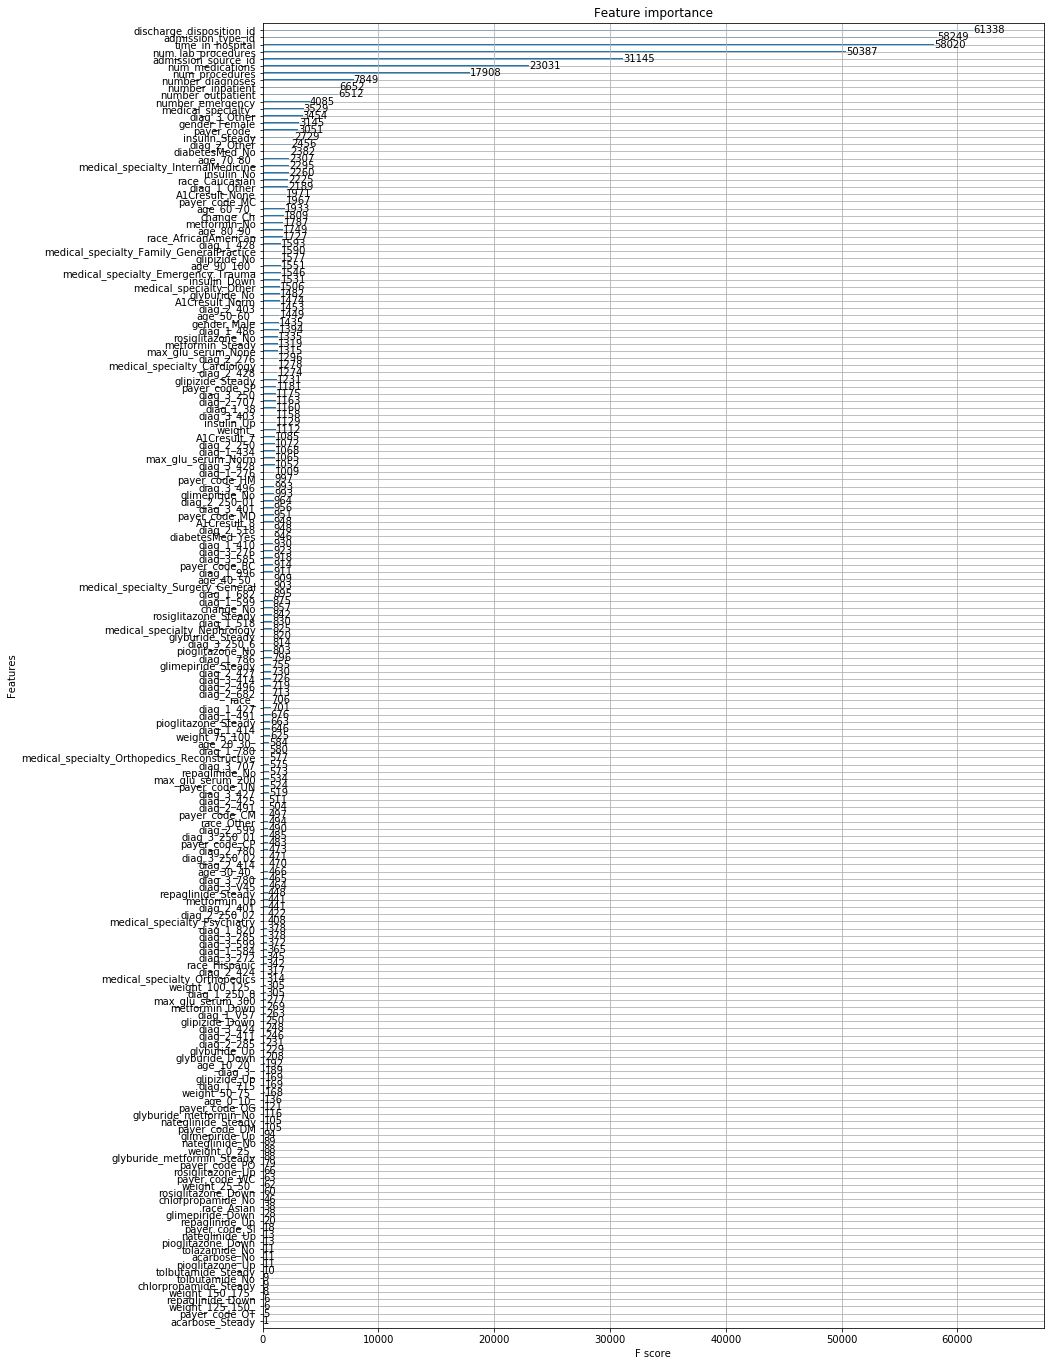

In [36]:
fig, ax = plt.subplots(figsize=(14, 24))
_ = plot_importance(model, ax=ax)

#### Shapley variable importance

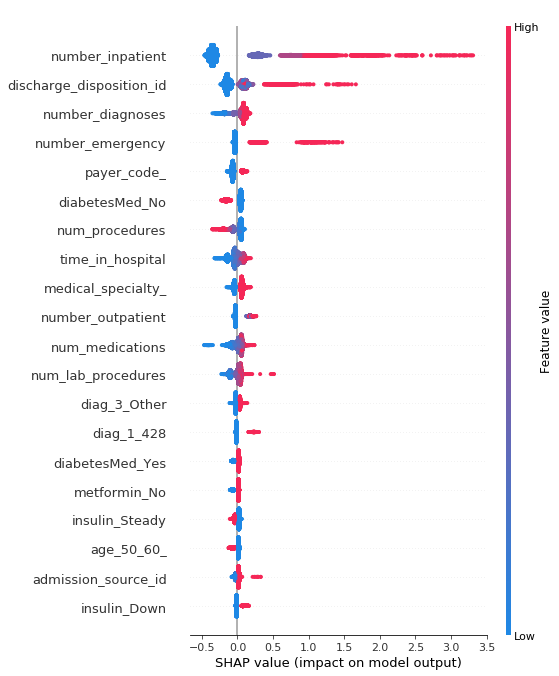

In [41]:
shap_values = model.predict(dtest, pred_contribs=True)
shap.summary_plot(shap_values, test[X])

#### Example Shapley dependence (you can try other variables)

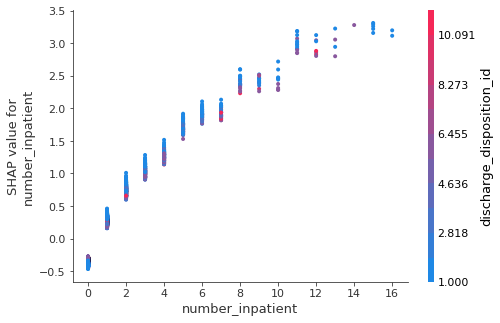

In [42]:
var = 'number_inpatient'
shap.dependence_plot(var, shap_values, test[X])

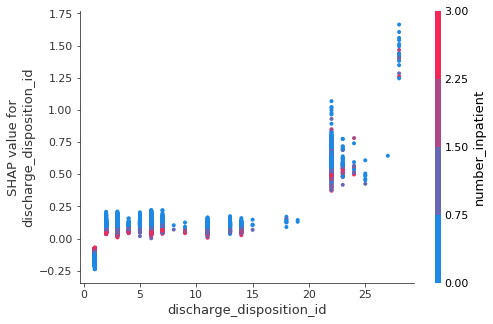

In [43]:
var = 'discharge_disposition_id'
shap.dependence_plot(var, shap_values, test[X])

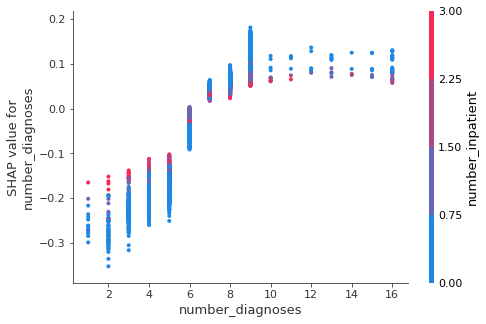

In [44]:
var = 'number_diagnoses'
shap.dependence_plot(var, shap_values, test[X])

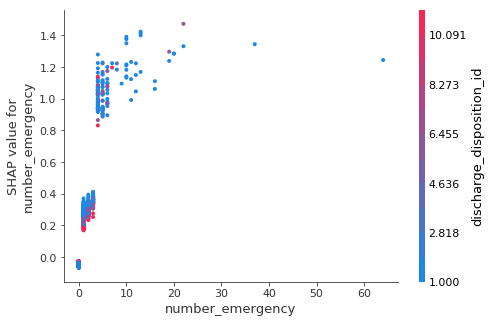

In [46]:
var = 'number_emergency'
shap.dependence_plot(var, shap_values, test[X])

#### Function for calculating partial dependence

In [47]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

#### Calculate partial dependence for the most important input variables in the GBM

In [50]:
par_dep_number_inpatient = par_dep('number_inpatient', test[X], model)
par_dep_discharge_disposition_id = par_dep('discharge_disposition_id', test[X], model)
par_dep_number_diagnoses = par_dep('number_diagnoses', test[X], model)
par_dep_number_emergency = par_dep('number_emergency', test[X], model)

#### Add row ID column to test set for later joins

In [52]:
test['ID'] = np.arange(test.shape[0])

#### Bind XGBoost predictions to training data

In [53]:
xgb_preds = pd.DataFrame(model.predict(dtest))

In [54]:
test.reset_index(inplace=True)
test.drop(['index'], inplace=True, axis=1)

In [55]:
decile_frame = pd.concat([test, xgb_preds], axis=1)
decile_frame = decile_frame.rename(columns={0: 'predict'})
decile_hframe = h2o.H2OFrame(decile_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [56]:
decile_frame.head()

,id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,acetohexamide,examide,citoglipton,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,readmitted,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,tolbutamide_No,tolbutamide_Steady,medical_specialty_,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_,diag_3_Other,diag_3_V45,miglitol_Down,miglitol_No,miglitol_Steady,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,glipizide_metformin_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,glyburide_metformin_No,glyburide_metformin_Steady,change_Ch,change_No,tolazamide_No,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,payer_code_,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,chlorpropamide_No,chlorpropamide_Steady,gender_Female,gender_Male,gender_Unknown_Invalid,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,weight_,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,acarbose_No,acarbose_Steady,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,troglitazone_No,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,diabetesMed_No,diabetesMed_Yes,race_,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,ID,predict
0,240277404,34289775,1,1,7,1,50,6,25,0,0,0,9,No,No,No,No,No,No,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0.112585
1,240282048,59363082,3,1,1,2,1,1,1,0,0,0,6,No,No,No,No,No,No,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0.045738
2,240334590,88735698,3,1,1,5,47,6,13,3,0,0,9,No,No,No,No,No,No,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### Find percentiles of XGBoost predictions

In [58]:
ds_ = DataMakerAndGetter()
percentile_dict = ds_.get_percentile_dict('predict', 'ID', decile_hframe)

In [59]:
percentile_dict

{0: 5518,
 10: 9921,
 20: 15635,
 30: 5907,
 40: 13860,
 50: 8290,
 60: 2675,
 70: 10881,
 80: 9005,
 90: 13803,
 99: 3354}

#### Calculate ICE curve values

In [61]:
# retreive bins from original partial dependence calculation
bins_number_inpatient = list(par_dep_number_inpatient['number_inpatient'])
bins_discharge_disposition_id = list(par_dep_discharge_disposition_id['discharge_disposition_id'])
bins_number_diagnoses = list(par_dep_number_diagnoses['number_diagnoses'])
bins_number_emergency = list(par_dep_number_emergency['number_emergency'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves across percentiles 
    par_dep_number_inpatient[col_name] = par_dep('number_inpatient', 
                                                 test[test['ID'] == int(percentile_dict[i])][X], 
                                                 model, 
                                                 bins=bins_number_inpatient)['partial_dependence']

    par_dep_discharge_disposition_id[col_name] = par_dep('discharge_disposition_id', 
                                                         test[test['ID'] == int(percentile_dict[i])][X], 
                                                         model, 
                                                         bins=bins_discharge_disposition_id)['partial_dependence']

    par_dep_number_diagnoses[col_name] = par_dep('number_diagnoses', 
                                                 test[test['ID'] == int(percentile_dict[i])][X], 
                                                 model, 
                                                 bins=bins_number_diagnoses)['partial_dependence']
    
    par_dep_number_emergency[col_name] = par_dep('number_emergency', 
                                                 test[test['ID'] == int(percentile_dict[i])][X], 
                                                 model, 
                                                 bins=bins_number_emergency)['partial_dependence']


#### Plot partial dependence and ICE

In [62]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


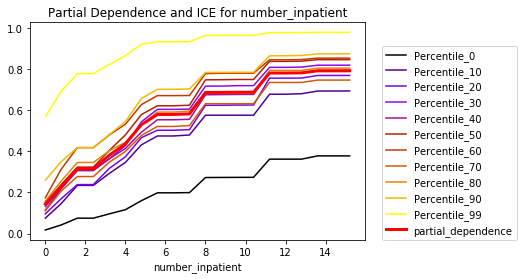

In [63]:
plot_par_dep_ICE('number_inpatient', par_dep_number_inpatient)

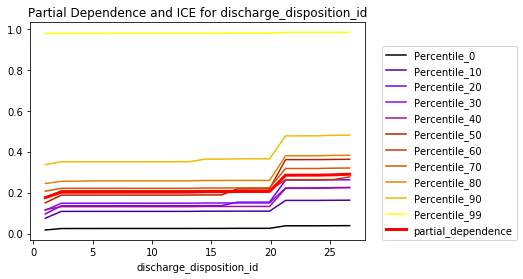

In [64]:
plot_par_dep_ICE('discharge_disposition_id', par_dep_discharge_disposition_id)

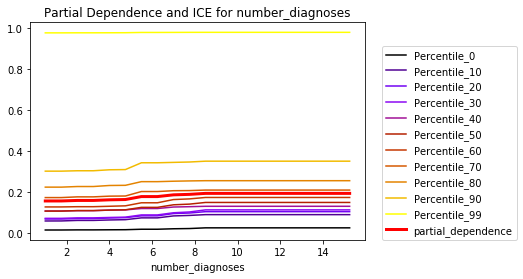

In [65]:
plot_par_dep_ICE('number_diagnoses', par_dep_number_diagnoses)

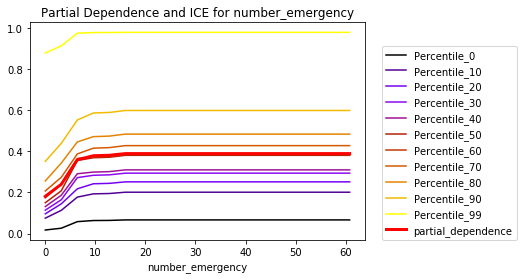

In [66]:
plot_par_dep_ICE('number_emergency', par_dep_number_emergency)

#### Train single h2o decision tree

In [93]:
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=5,       # shallow trees are easier to understand
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y='predict', training_frame=decile_hframe)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

Generated MOJO path:
 /home/patrickh/workspace/diabetes_use_case/dt_surrogate_mojo.zip


#### Create GraphViz dot file

In [100]:
# title for plot
title = 'Diabetes Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/workspace/diabetes_use_case/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Diabetes Decision Tree Surrogate


#### Create PNG from GraphViz dot file and display

In [101]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


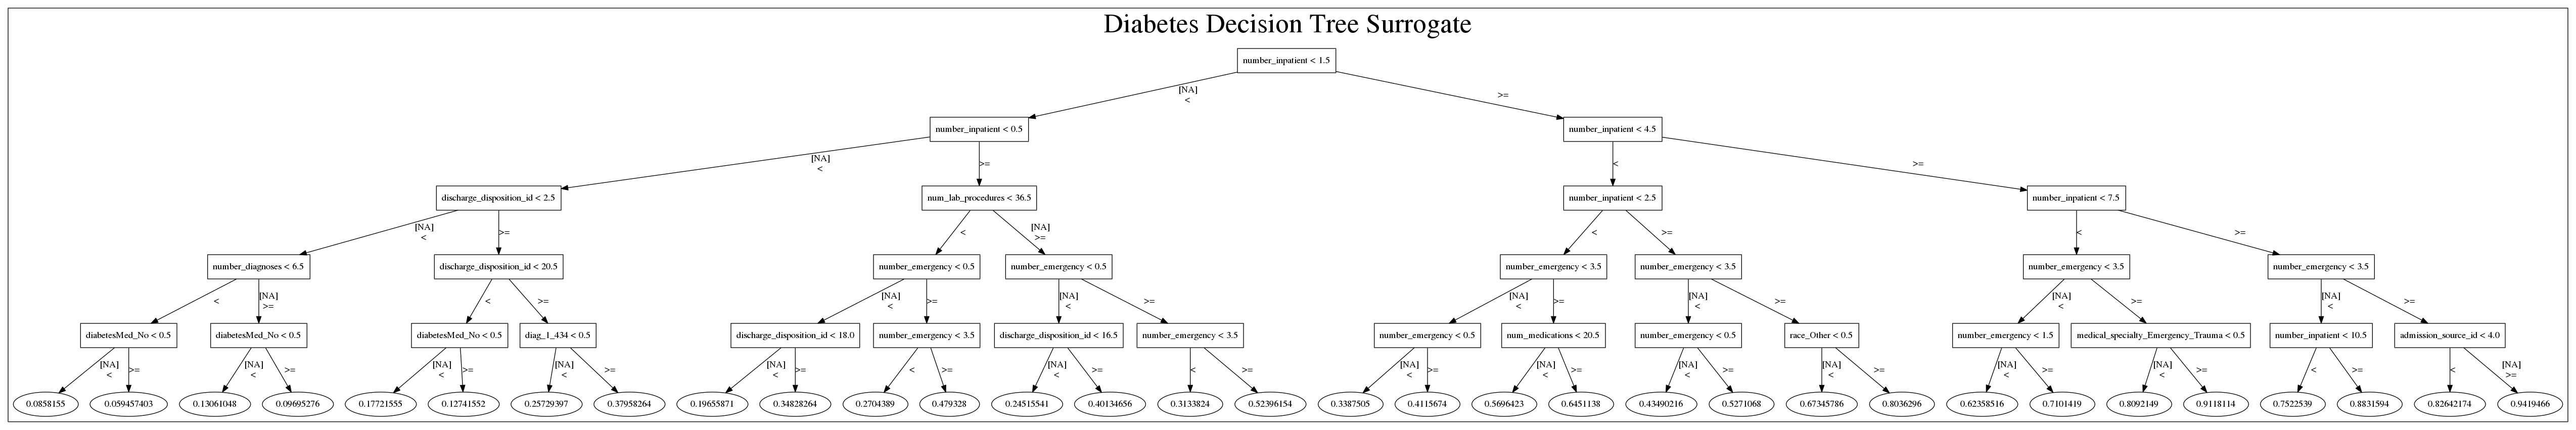

In [102]:
# display in-notebook
display(Image((png_file_name)))

# Local Explanations (variable importance) at Several Percentiles of Model Predictions

***

#### Utility function that displays the TreeInterpreter plot at the chosen decile 

In [114]:
def eli5_dd(decile):
    row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]
    eli5_df = eli5.explain_prediction_df(model, row[X].iloc[0]).sort_values(by='weight', ascending=True)
    _ = eli5_df[['feature', 'weight']].iloc[-5:,:].plot(kind='bar', title='Approximate Local Contributions', x='feature', legend=False)
    return eli5.explain_prediction_xgboost(model, row[X].iloc[0])

#### Utility function that displays the LIME result at the choosen decile

In [115]:
# learn what to discretize from var imp 
explainer = LIMEExplainer(training_frame=test, X=X, model=model, discretize=['number_inpatient', 'discharge_disposition_id', 'number_diagnoses', 'number_emergency'])

def lime(decile):
    row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]
    explainer.explain(row.index[0]) 

#### Utility function that displays the Shapley results at the choosen decile

In [116]:
def shapley(row):
    s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(192, 1), columns=['Approximate Local Contributions'], index=X)
    s_df = s_df.sort_values(by='Approximate Local Contributions')
    print(s_df, '\n')
    _= s_df.iloc[-5:,:].plot(kind='bar', title='Approximate Local Contributions', legend=False)
    print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
    p = row['predict'].values[0]
    print('Model prediction: ', np.log(p/(1 - p)))

##  10th decile of model predictions

In [117]:
decile = 10
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

### Shapley values

                                              Approximate Local Contributions
number_inpatient                                                    -0.381572
discharge_disposition_id                                            -0.173257
time_in_hospital                                                    -0.150005
num_lab_procedures                                                  -0.087680
medical_specialty_Other                                             -0.069922
payer_code_                                                         -0.068397
number_diagnoses                                                    -0.051175
medical_specialty_                                                  -0.050048
number_emergency                                                    -0.039840
number_outpatient                                                   -0.031915
admission_source_id                                                 -0.026135
diag_3_V45                                                      

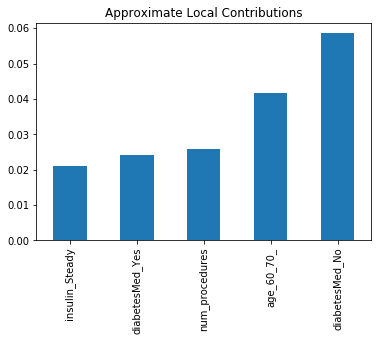

In [118]:
shapley(row)

##  Median of predictions

In [126]:
decile = 50
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

### Shapley values

                                              Approximate Local Contributions
number_inpatient                                                    -0.342671
discharge_disposition_id                                            -0.180120
num_lab_procedures                                                  -0.097391
payer_code_                                                         -0.068728
metformin_No                                                        -0.059811
time_in_hospital                                                    -0.044941
number_emergency                                                    -0.037496
metformin_Steady                                                    -0.037170
insulin_Steady                                                      -0.037130
A1Cresult_None                                                      -0.037026
number_outpatient                                                   -0.027356
diag_1_428                                                      

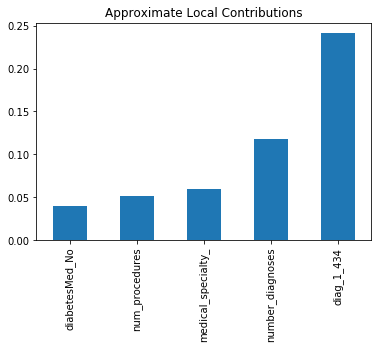

In [127]:
shapley(row)

##  90th decile of model predictions

In [128]:
decile = 90
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

### Shapley values

                                          Approximate Local Contributions
num_procedures                                                  -0.104141
payer_code_                                                     -0.069913
number_emergency                                                -0.036204
number_outpatient                                               -0.028160
diag_3_Other                                                    -0.022892
diag_1_428                                                      -0.017804
medical_specialty_Emergency_Trauma                              -0.013847
gender_Female                                                   -0.012533
age_60_70_                                                      -0.011181
diag_2_403                                                      -0.008854
insulin_Down                                                    -0.008836
diag_1_996                                                      -0.008766
diag_1_Other                          

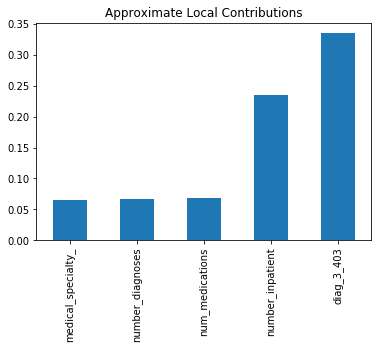

In [129]:
shapley(row)